# Setup

## Importing libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import pickle

## Importing our dataset

Dataset: https://github.com/chrisdonahue/nesmdb

In [3]:
import requests 
url = "http://deepyeti.ucsd.edu/cdonahue/nesmdb/nesmdb_midi.tar.gz"
  
r = requests.get(url)

with open("dataset.tar.gz",'wb') as f: 
    f.write(r.content) 

In [4]:
import tarfile
my_tar = tarfile.open('dataset.tar.gz')
my_tar.extractall('./dataset')
my_tar.close()

## Setting up global variables

# Preparation

## Utility functions

I used modified version of https://github.com/HackerPoet/Composer/blob/master/midi.py for sample to midi and midi to sample tranformations (I couldn't get my own code to work properly). All credits for the following code paragraph to the autor.

In [5]:
pip install mido

     |████████████████████████████████| 61kB 4.1MB/s 


In [6]:
from mido import MidiFile, MidiTrack, Message
import numpy as np

num_notes = 128
samples_per_measure = 96

def midi_to_samples(fname):
	has_time_sig = False
	flag_warning = False
	mid = MidiFile(fname)
	ticks_per_beat = mid.ticks_per_beat
	ticks_per_measure = 4 * ticks_per_beat

	for i, track in enumerate(mid.tracks):
		for msg in track:
			if msg.type == 'time_signature':
				new_tpm = msg.numerator * ticks_per_beat * 4 / msg.denominator
				if has_time_sig and new_tpm != ticks_per_measure:
					flag_warning = True
				ticks_per_measure = new_tpm
				has_time_sig = True
	if flag_warning:
		print ("  ^^^^^^ WARNING ^^^^^^")
		print ("    " + fname)
		print ("    Detected multiple distinct time signatures.")
		print ("  ^^^^^^ WARNING ^^^^^^")
		return []
	
	all_notes = {}
	for i, track in enumerate(mid.tracks[1:4]):
		abs_time = 0
		for msg in track:
			abs_time += msg.time
			if msg.type == 'note_on':
				if msg.velocity == 0:
					continue
				note = msg.note - (128 - num_notes)/2
				assert(note >= 0 and note < num_notes)
				if note not in all_notes:
					all_notes[note] = []
				else:
					single_note = all_notes[note][-1]
					if len(single_note) == 1:
						single_note.append(single_note[0] + 1)
				all_notes[note].append([abs_time * samples_per_measure / ticks_per_measure])
			elif msg.type == 'note_off':
				if len(all_notes[note][-1]) != 1:
					continue
				all_notes[note][-1].append(abs_time * samples_per_measure / ticks_per_measure)
	for note in all_notes:
		for start_end in all_notes[note]:
			if len(start_end) == 1:
				start_end.append(start_end[0] + 1)
	samples = []
	for note in all_notes:
		note=int(note)
		for start, end in all_notes[note]:
			sample_ix = int(start / samples_per_measure)
			while len(samples) <= sample_ix:
				samples.append(np.zeros((samples_per_measure, num_notes), dtype=np.uint8))
			sample = samples[sample_ix]
			start_ix = int(start - sample_ix * samples_per_measure)
			if False:
				end_ix = min(end - sample_ix * samples_per_measure, samples_per_measure)
				while start_ix < end_ix:
					sample[start_ix, note] = 1
					start_ix += 1
			else:
				sample[start_ix, note] = 1
	return samples

def samples_to_midi(samples, fname, ticks_per_sample, thresh=0.5):
	mid = MidiFile()
	track = MidiTrack()
	mid.tracks.append(track)
	ticks_per_beat = mid.ticks_per_beat
	ticks_per_measure = 4 * ticks_per_beat
	ticks_per_sample = ticks_per_measure / samples_per_measure
	abs_time = 0
	last_time = 0
	for sample in samples:
		for y in range(sample.shape[0]):
			abs_time += ticks_per_sample
			for x in range(sample.shape[1]):
				note = x + (128 - num_notes)/2
				if sample[y,x] >= thresh and (y == 0 or sample[y-1,x] < thresh):
					delta_time = abs_time - last_time
					track.append(Message('note_on', note=int(note), velocity=127, time=int(delta_time)))
					last_time = abs_time
				if sample[y,x] >= thresh and (y == sample.shape[0]-1 or sample[y+1,x] < thresh):
					delta_time = abs_time - last_time
					track.append(Message('note_off', note=int(note), velocity=127, time=int(delta_time)))
					last_time = abs_time
	mid.save(fname)

## Preparing the dataset

# Creating the model

In [7]:
inputs = keras.Input((128,96,16))
inputs.shape

TensorShape([None, 128, 96, 16])

In [8]:
x = layers.Reshape((16,12288))(inputs)
print(x.shape)
x = layers.TimeDistributed(layers.Dense(2000))(x)
print(x.shape)
x = layers.TimeDistributed(layers.Dense(200))(x)
print(x.shape)
x = layers.Flatten()(x)
print(x.shape)

(None, 16, 12288)
(None, 16, 2000)
(None, 16, 200)
(None, 3200)


In [9]:
x = layers.Dense(1600)(x)
print(x.shape)
x = layers.Dense(120)(x)
print(x.shape)
x = layers.BatchNormalization(name='pre-encoder')(x)
print(x.shape)

(None, 1600)
(None, 120)
(None, 120)


In [10]:
x = layers.Dense(1600, name='encoder')(x)
print(x.shape)
x = layers.BatchNormalization()(x)
print(x.shape)
x = layers.Activation(activation='relu')(x)
print(x.shape)
x = layers.Dense(16*200)(x)
print(x.shape)
x = layers.Reshape((16,200))(x)
print(x.shape)

(None, 1600)
(None, 1600)
(None, 1600)
(None, 3200)
(None, 16, 200)


In [11]:
x = layers.TimeDistributed(layers.BatchNormalization())(x)
print(x.shape)
x = layers.Activation(activation='relu')(x)
print(x.shape)
x = layers.TimeDistributed(layers.Dense(2000))(x)
print(x.shape)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
print(x.shape)
x = layers.Activation('relu')(x)

(None, 16, 200)
(None, 16, 200)
(None, 16, 2000)
(None, 16, 2000)


In [12]:
x = layers.TimeDistributed(layers.Dense(128*96,activation='sigmoid'))(x)
print(x.shape)
x = layers.Reshape((128,96,16))(x)
print(x.shape)

(None, 16, 12288)
(None, 128, 96, 16)


In [13]:
model = keras.Model(inputs,x)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1),loss='binary_crossentropy') #TODO: try RMSprop

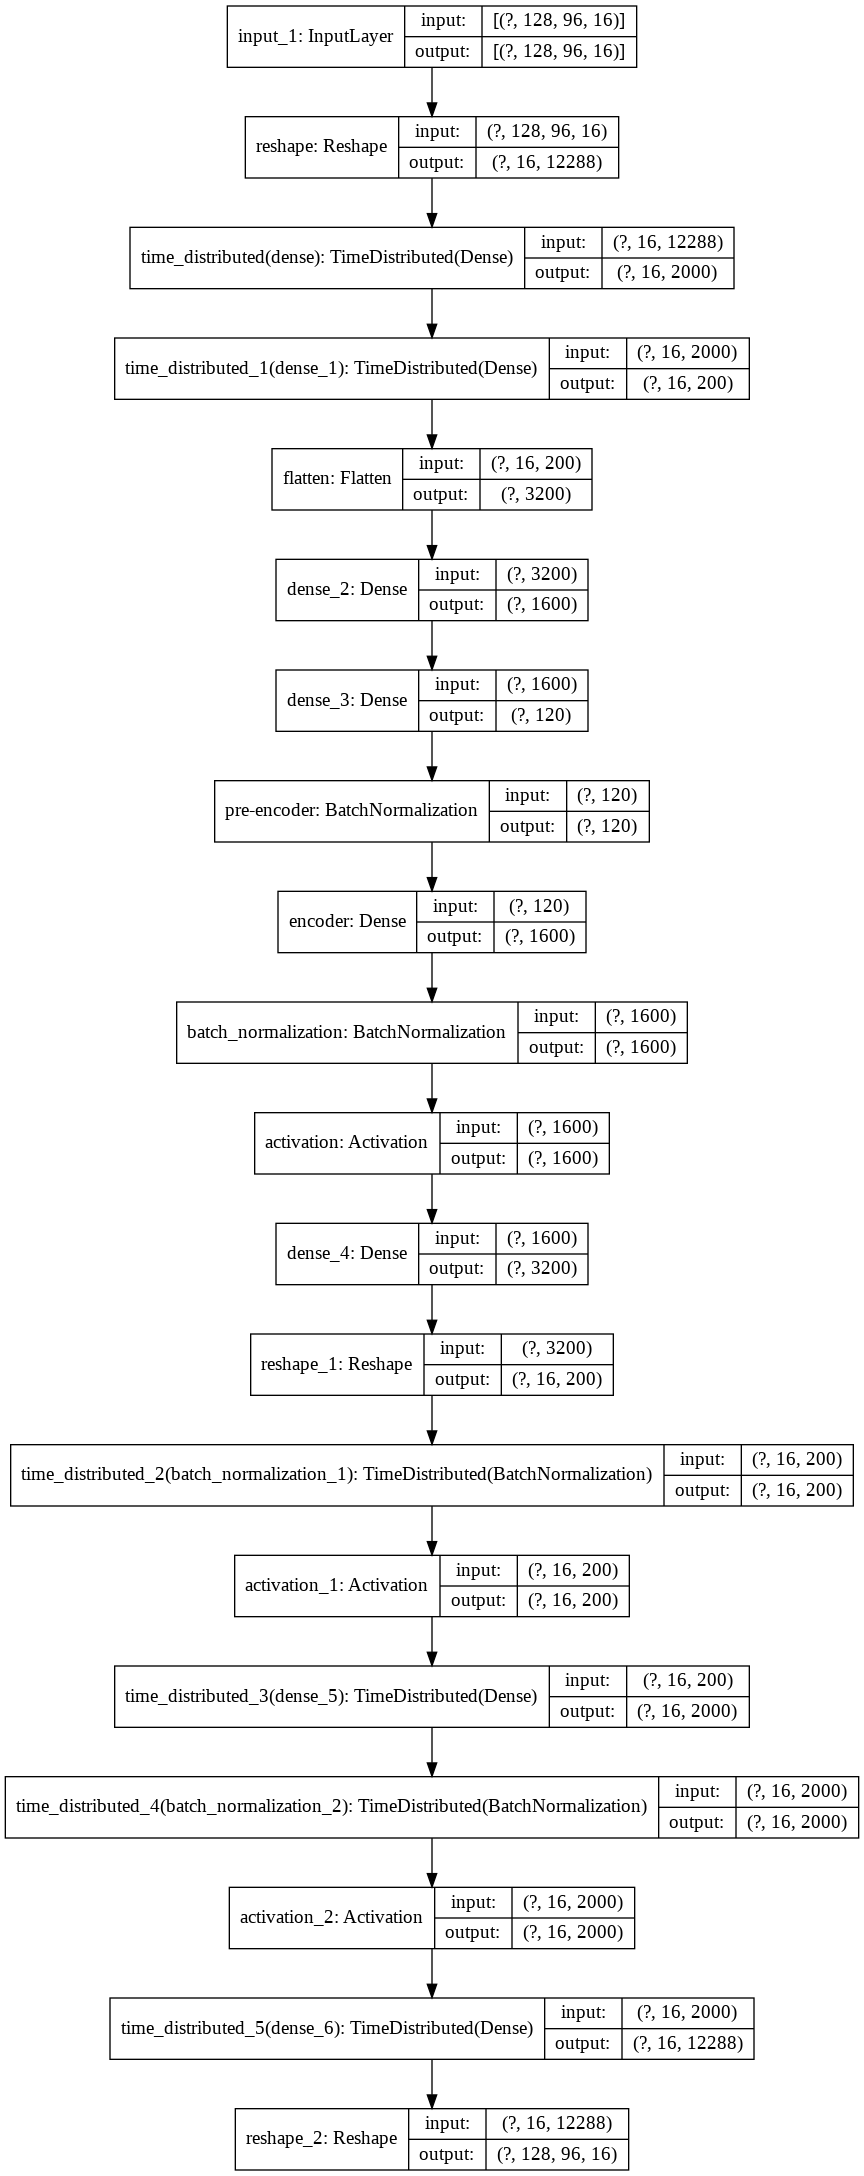

In [14]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

# Training the model

In [15]:
import glob;
from numpy import reshape

In [16]:
s_train = [midi_to_samples(filename) for filename in glob.iglob('dataset/nesmdb_midi/train/*.mid')]
s_test = [midi_to_samples(filename) for filename in glob.iglob('dataset/nesmdb_midi/test/*.mid')]
s_valid = [midi_to_samples(filename) for filename in glob.iglob('dataset/nesmdb_midi/valid/*.mid')]

In [17]:
for i in range(len(s_train)):
  s_train[i]=[s_train[i]*16][0][:16]
for i in range(len(s_test)):
  s_test[i]=[s_test[i]*16][0][:16]
for i in range(len(s_valid)):
  s_valid[i]=[s_valid[i]*16][0][:16]

In [18]:
x_train = np.array(s_train)
x_test = np.array(s_test)
x_valid = np.array(s_valid)

In [19]:
for i in range(len(x_train)):
  if(np.array(x_train[i]).shape != np.array(x_train[0]).shape): x_train[i] = x_train[0]
for i in range(len(x_test)):
  if(np.array(x_test[i]).shape != np.array(x_test[0]).shape): x_test[i] = x_test[0]
for i in range(len(x_valid)):
  if(np.array(x_valid[i]).shape != np.array(x_valid[0]).shape): x_valid[i] = x_valid[0]

In [20]:
x_train = reshape(np.concatenate(x_train),(-1,16,96,128))
x_test = reshape(np.concatenate(x_test),(-1,16,96,128))
x_valid = reshape(np.concatenate(x_valid),(-1,16,96,128))

In [21]:
x_train = x_train.swapaxes(1,3)
x_test = x_test.swapaxes(1,3)
x_valid = x_valid.swapaxes(1,3)

In [22]:
train_step = 0
for i in [1,5,10,20,50,100]:
  model.fit(x_train, x_train,
                epochs=i-train_step,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test),)
  train_step = i
  model.save('model 2.2-epoch'+str(i))

141/141 [==============================] - 304s 2s/step - loss: 0.0332 - val_loss: 0.0248
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model 2.2-epoch1/assets
Epoch 1/4
141/141 [==============================] - 304s 2s/step - loss: 0.0273 - val_loss: 0.0242
Epoch 2/4
141/141 [==============================] - 303s 2s/step - loss: 0.0272 - val_loss: 0.0239
Epoch 3/4
141/141 [==============================] - 309s 2s/step - loss: 0.0272 - val_loss: 0.0240
Epoch 4/4
141/141 [==============================] - 307s 2s/step - loss: 0.0272 - val_loss: 0.0239
INFO:tensorflow:Assets written to: model 2.2-epoch5/assets
Epoch 1/5
141/141 [==============================] - 302s 2s/step - loss: 0.0170 - val_loss: 0.0174
Epoch 2/5
141/141 [==============================] - 303s 

In [44]:
model = keras.models.load_model('model 2.2-epoch100')

# Creating and exporting the generator

In [45]:
tf.compat.v1.disable_eager_execution()

func = keras.backend.function([model.get_layer('encoder').input, keras.backend.learning_phase()],
			  	[model.layers[-1].output])

In [46]:
arr = np.array([np.random.normal() for i in range(120)])
arr = np.matrix(arr)

In [50]:
samples_to_midi(func(arr)[0][0],'out01.midi',96, thresh=0.01)

Wynik: nie działa (prawdopodobnie wina zestawu danych). Uczy się nie grać odpowiednich nut, ale grane nie mają nic ze sobą wspólnego